# [Purpose] Pytorch Dataloader for speaker identification

### ||Given Data||  One folder composed of subfolders according to each speaker's index including .flac files
### ||Dataloader||   Input data: (Batch size x Mel-spectrogram) / Target data: (Batch size x Speaker index)

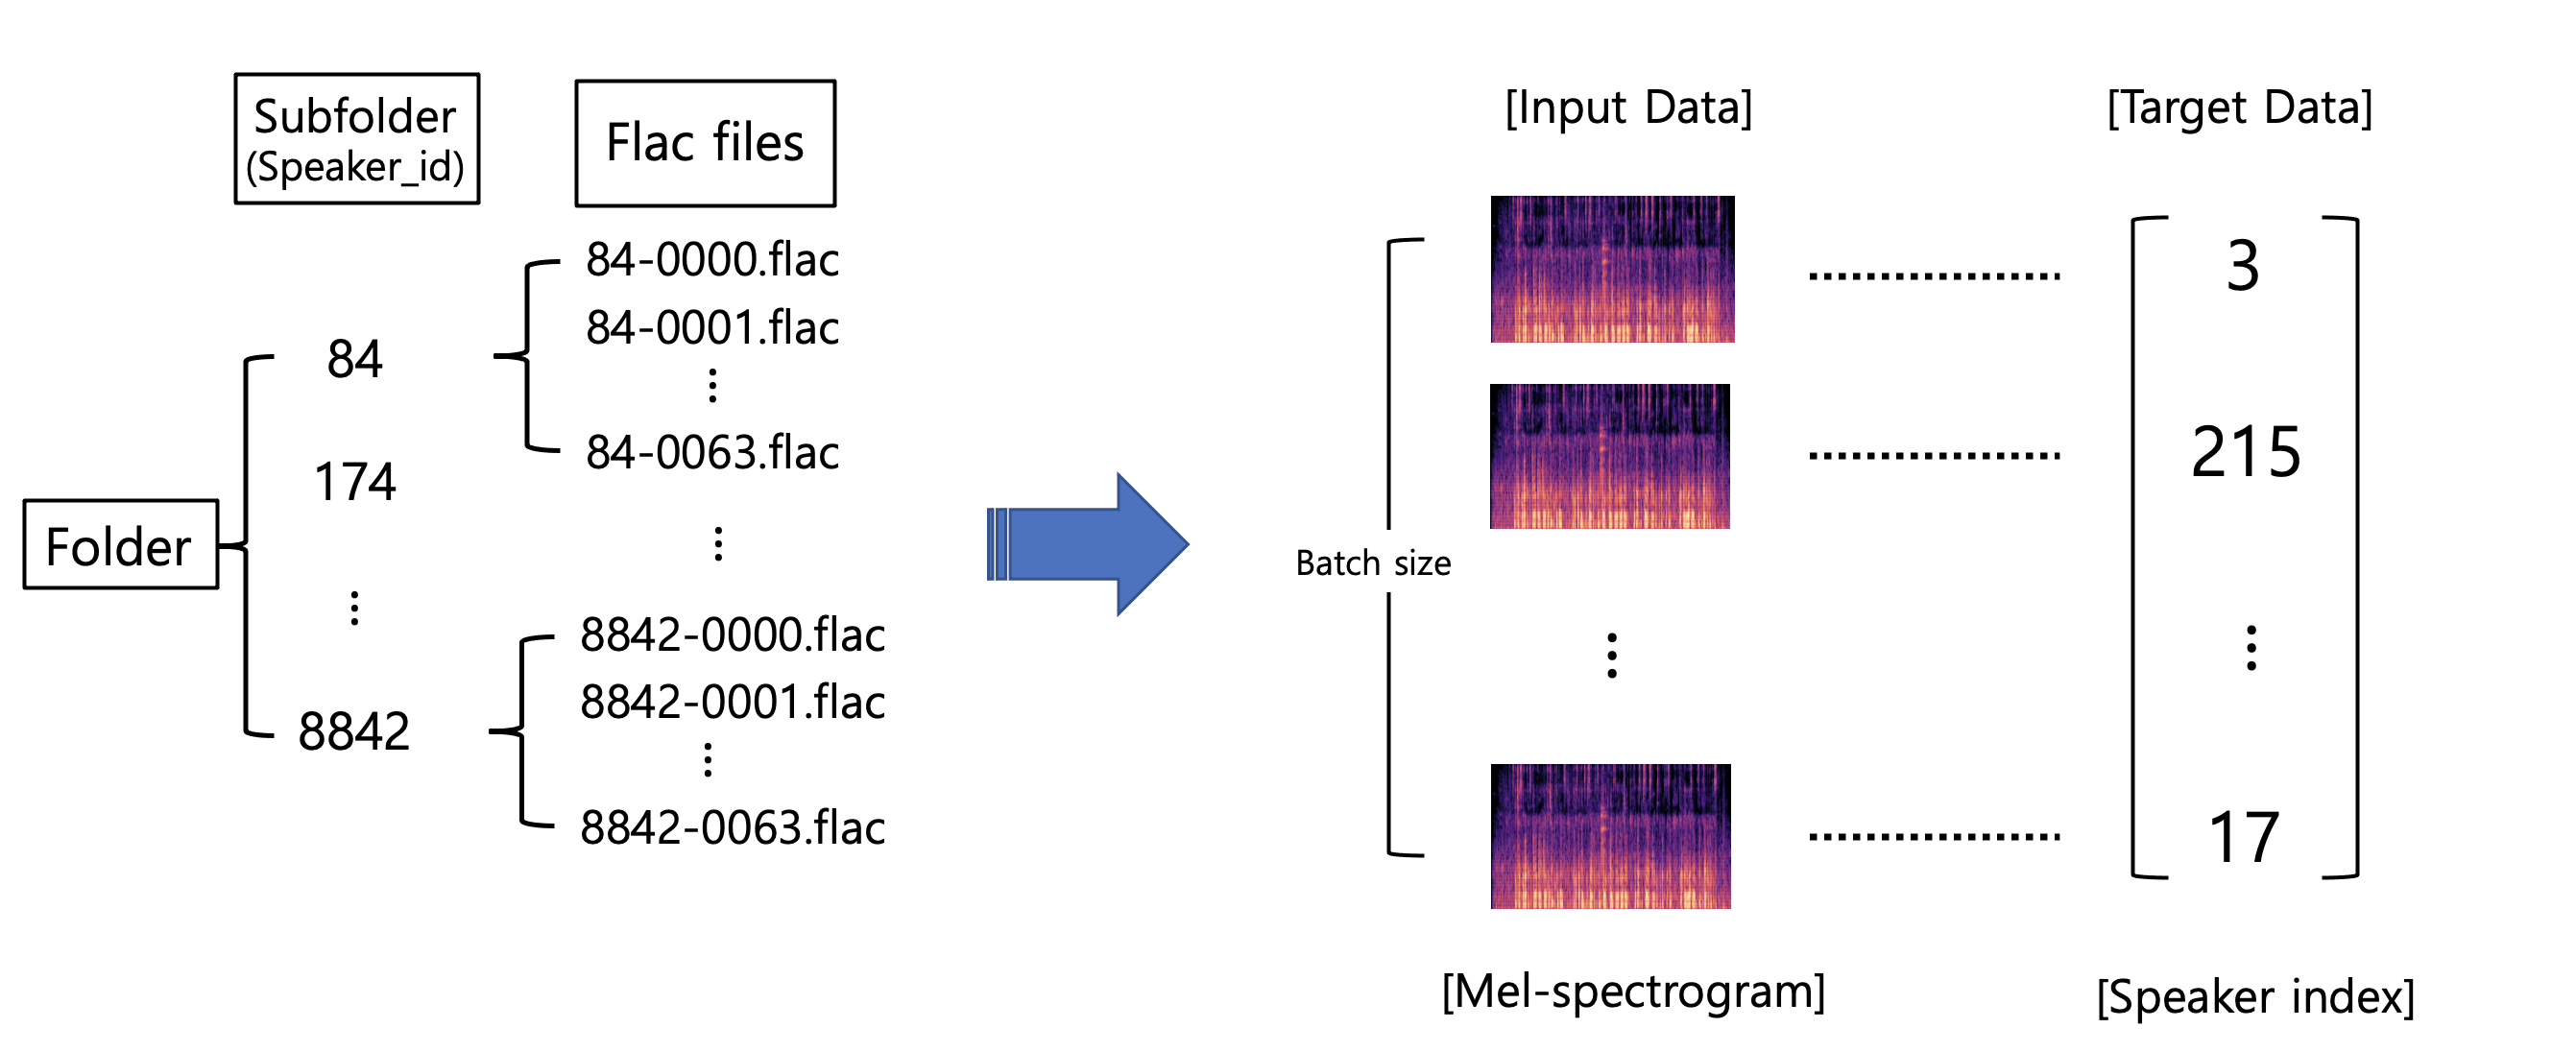

In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from torch import Tensor
import librosa
torch.manual_seed(1)

# [Load Data]

In [2]:
def FolderToPath_Idx(folder):
    '''Get the folder directory and return list of whole data samples
       in type of tuple(path of flac file, each speaker's index)'''
    
    all_idxs = [d for d in os.listdir(folder)]
    data = []
    for idx in all_idxs:
        idx_files = glob.glob(folder+idx+'/**/*.flac', recursive=True)
        for path in idx_files:
            data.append((path,idx))
    return data

# [Dataset]

In [3]:
class CustomDataset(Dataset):
    def __init__(self, folder, transform=None):
        '''load data'''
        
        data = FolderToPath_Idx(folder) 
        #data: list of whole data with type of tuple (flac file path, each speaker's index)
        self.data = data
        self.transform = transform
        
    def __len__(self):
        '''return whole length of dataset'''
        
        return len(self.data)

    def __getitem__(self, index):
        '''return one data with given index for training'''
        
        path, target = self.data[index]
        target = torch.Tensor([int(target)])
        idx_data = {'path_wave': path, 'target': target}

        if self.transform is not None:   
            idx_data = self.transform(idx_data)
            #process data by transform
            
        return idx_data

# [Transform]

### Implement 4 transform classes

### 1. LoadAudio : Get t-domain data(numpy array) using librosa
### 2. FixAudioLength: Converts t-domain data to a fixed length based on one second.
### 3. ToMelSpectrogram: Converts t-domain data to f-domain Log Mel-Spectrogram
### 4. ToTensor: Converts Numpy to Tensor

In [4]:
class LoadAudio(object):
    '''Get time-domain data(numpy array) using librosa'''
    def __init__(self, sample_rate=16000):
        self.sample_rate = sample_rate

    def __call__(self, data):
        #data: dictionary
        path = data['path_wave']
        samples, sample_rate = librosa.load(path, self.sample_rate)
        data['samples'] = samples
        data['sample_rate'] = sample_rate
        #add sample: waveform, sampling_rate: sample_rate to data dictionary
        return data

In [5]:
class FixAudioLength(object):
    """Either pads or truncates an audio into a fixed length"""

    def __init__(self, time=1):
        self.time = time

    def __call__(self, data):
        samples = data['samples']
        sample_rate = data['sample_rate']
        length = int(self.time * sample_rate)
        if length < len(samples):
            data['samples'] = samples[:length]
        elif length > len(samples):
            data['samples'] = np.pad(samples, (0, length - len(samples)), "constant")
        return data

In [6]:
class ToMelSpectrogram(object):
    """Creates the mel spectrogram from an audio"""

    def __init__(self, n_mels=32):
        self.n_mels = n_mels

    def __call__(self, data):
        samples = data['samples']
        sample_rate = data['sample_rate']
        s = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=self.n_mels)
        data['mel_spectrogram'] = librosa.power_to_db(s, ref=np.max)
        return data

In [7]:
class ToTensor(object):
    """Converts into a tensor"""

    def __init__(self, np_name, tensor_name):
        self.np_name = np_name
        self.tensor_name = tensor_name

    def __call__(self, data):
        tensor = torch.FloatTensor(data[self.np_name])
        data[self.tensor_name] = tensor
        return data

# [Transform.Compose]

### Class that chain transform classes to do defined works



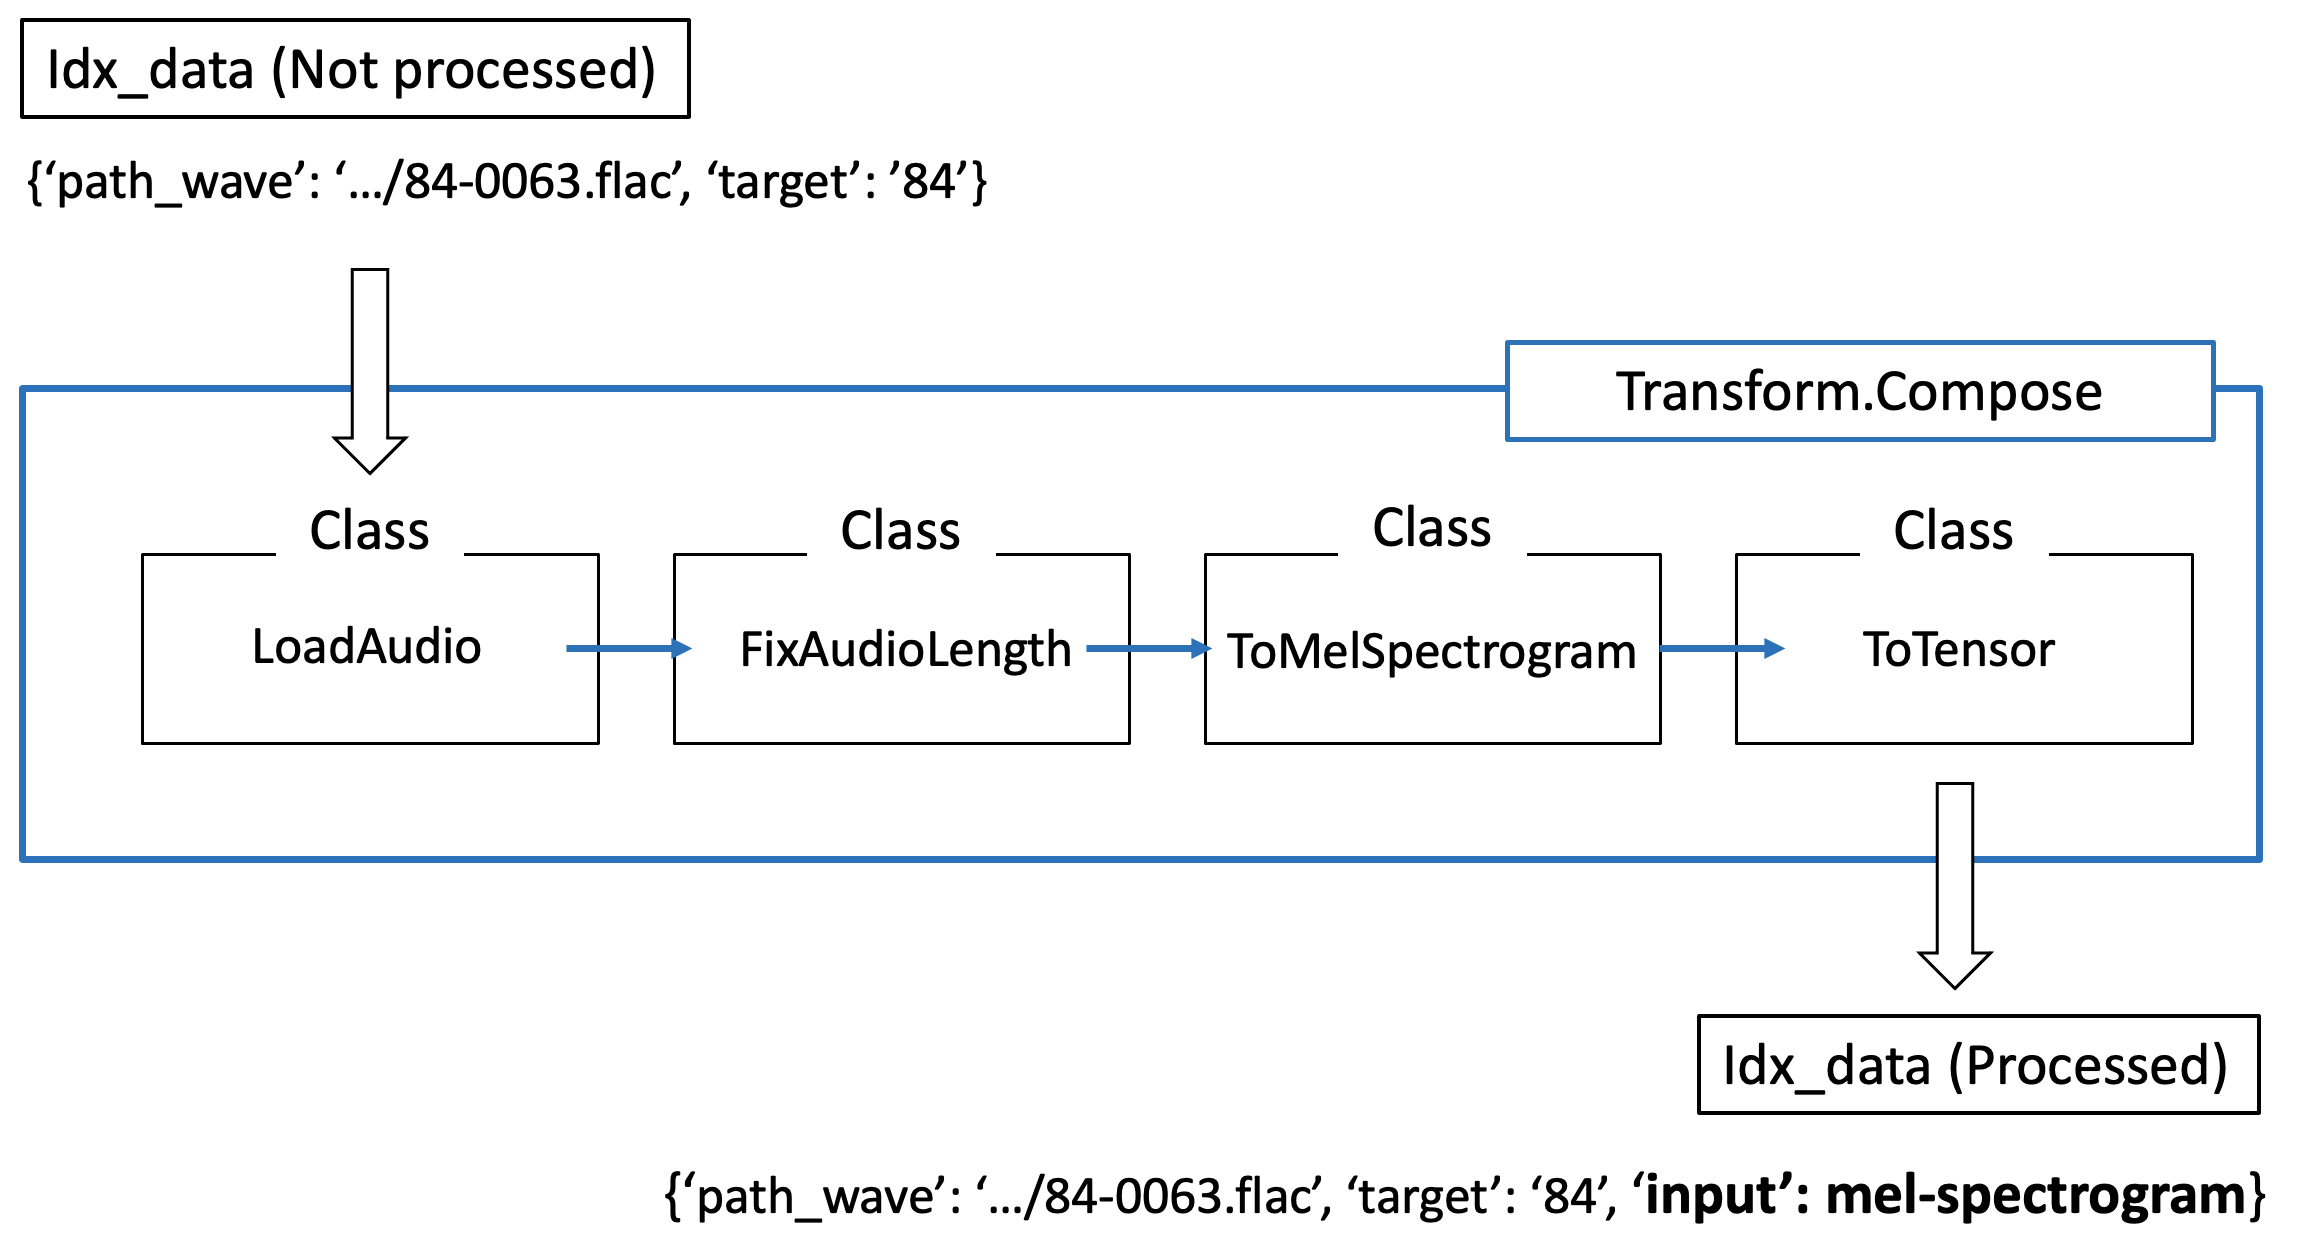

In [8]:
'''Check whether it works'''

ex_data = {'path_wave':os.getcwd()+'/LibriSpeech/dev-clean/84/121123/84-121123-0000.flac', 'target':'84'}

_loadaudio = LoadAudio()
_fixaudiolength = FixAudioLength()
_melSpec = ToMelSpectrogram()
composed = transforms.Compose([LoadAudio(),
                                FixAudioLength(),
                                ToMelSpectrogram(n_mels=40), 
                                ToTensor('mel_spectrogram', 'input')])

transformed_sample = composed(ex_data)

print('Value corresponding to key \'input\' is Mel_spectrogram\nIts size:', transformed_sample['input'].size())

Value corresponding to key 'input' is Mel_spectrogram
Its size: torch.Size([40, 32])


# [Apply to Dataset/DataLoader]

In [9]:
path_dataset = os.getcwd()+'/LibriSpeech/dev-clean/'
n_mels=40
batch_size=4

dataset = CustomDataset(path_dataset,transforms.Compose([LoadAudio(),
                                                    FixAudioLength(),
                                                    ToMelSpectrogram(n_mels=n_mels),
                                                    ToTensor('mel_spectrogram', 'input')]))

dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,
                                         shuffle=True,drop_last=True)

for i, batch in enumerate(dataloader):
    inputs = batch['input']
    targets = batch['target']
    
    if i<2:
        print('------- || batch',i+1,'||---------\n')
        print('input data shape:  ',inputs.size(),'\ntarget data shape: ',targets.size())
        print('\n<input data>\n\n',inputs,'\n\n<target data>\n\n',targets,'\n')

------- || batch 1 ||---------

input data shape:   torch.Size([4, 40, 32]) 
target data shape:  torch.Size([4, 1])

<input data>

 tensor([[[-26.9782, -23.8911, -16.4657,  ..., -16.4792, -15.7443, -13.0463],
         [-21.8659, -20.6667, -15.7637,  ..., -16.0504, -14.1141, -12.6148],
         [-23.7292, -22.5780, -17.8363,  ..., -12.3201, -10.5944,  -9.3579],
         ...,
         [-44.9113, -45.5743, -46.6800,  ..., -42.6374, -46.7652, -42.9251],
         [-44.2799, -44.4075, -46.3550,  ..., -44.0110, -55.7044, -52.8928],
         [-46.8420, -47.0788, -49.1507,  ..., -46.9060, -58.5200, -56.1505]],

        [[-72.2623, -69.8045, -70.1937,  ..., -55.1049, -39.8088, -30.3541],
         [-62.5008, -63.6855, -64.6970,  ..., -14.9667, -11.8205, -10.5471],
         [-62.5337, -63.2188, -63.6988,  ...,  -5.1464,  -7.5438,  -9.8166],
         ...,
         [-80.0000, -80.0000, -80.0000,  ..., -48.9868, -53.3580, -65.2878],
         [-80.0000, -80.0000, -80.0000,  ..., -56.0086, -58.4806, -7